In [1]:
from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np

from alternationprober.constants import (
    PATH_TO_BERT_WORD_EMBEDDINGS_FILE,
    PATH_TO_BERT_CONTEXT_WORD_EMBEDDINGS_FILE,
    PATH_TO_LAVA_DIR,
    PATH_TO_LAVA_VOCAB,
    PATH_TO_RESULTS_DIRECTORY,
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def sorting_key(layer_path):
    """Sort the result paths by the final directory, where ``static`` corresponds to layer 0."""
    if layer_path.stem == "static":
        key = 0
    else:
        key = int(layer_path.stem)
    return key

In [3]:
experiment_results = PATH_TO_RESULTS_DIRECTORY / "linear-probe-for-word-embeddings"

layer_paths = experiment_results.glob("*/")
layer_paths = sorted([path for path in layer_paths if path.is_dir()], key=sorting_key)
layer_paths

[PosixPath('/Users/jimmybru/Documents/UW/575-neural-lm/repo/results/linear-probe-for-word-embeddings/static'),
 PosixPath('/Users/jimmybru/Documents/UW/575-neural-lm/repo/results/linear-probe-for-word-embeddings/1'),
 PosixPath('/Users/jimmybru/Documents/UW/575-neural-lm/repo/results/linear-probe-for-word-embeddings/2'),
 PosixPath('/Users/jimmybru/Documents/UW/575-neural-lm/repo/results/linear-probe-for-word-embeddings/3'),
 PosixPath('/Users/jimmybru/Documents/UW/575-neural-lm/repo/results/linear-probe-for-word-embeddings/4'),
 PosixPath('/Users/jimmybru/Documents/UW/575-neural-lm/repo/results/linear-probe-for-word-embeddings/5'),
 PosixPath('/Users/jimmybru/Documents/UW/575-neural-lm/repo/results/linear-probe-for-word-embeddings/6'),
 PosixPath('/Users/jimmybru/Documents/UW/575-neural-lm/repo/results/linear-probe-for-word-embeddings/7'),
 PosixPath('/Users/jimmybru/Documents/UW/575-neural-lm/repo/results/linear-probe-for-word-embeddings/8'),
 PosixPath('/Users/jimmybru/Documents/UW/

In [4]:
layer_dfs = []
for i, layer_path in enumerate(layer_paths):
    for alternation_csv in layer_path.glob("*.csv"):
        if 'predictions' not in str(alternation_csv):
            layer_df = pd.read_csv(alternation_csv)
            layer_df['layer'] = i 
            layer_dfs.append(layer_df)
all_df = pd.concat(layer_dfs, axis=0)

frames = ['inchoative', 'causative', 'preposition', '2object', 
    'with', 'locative', 'No-There', 'There', 'Refl', 'Non-Refl']

In [5]:
# Reference MRRs from the CoLA MLP Model
ref_mcc = [0.555, 0, 0.32, 0.482, 0.645, 0.253, 0.459, 0, 0, 0.219]
ref = {frame:mcc for frame, mcc in zip(frames, ref_mcc)}
ref

{'inchoative': 0.555,
 'causative': 0,
 'preposition': 0.32,
 '2object': 0.482,
 'with': 0.645,
 'locative': 0.253,
 'No-There': 0.459,
 'There': 0,
 'Refl': 0,
 'Non-Refl': 0.219}

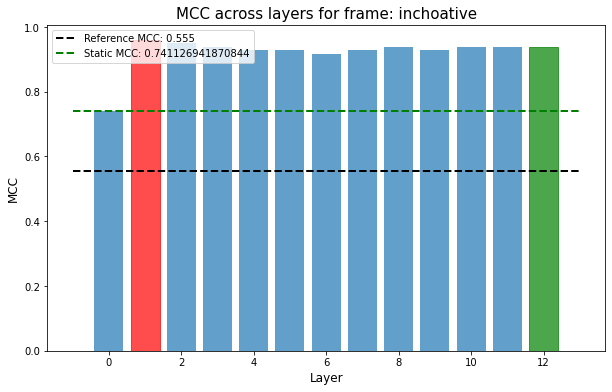

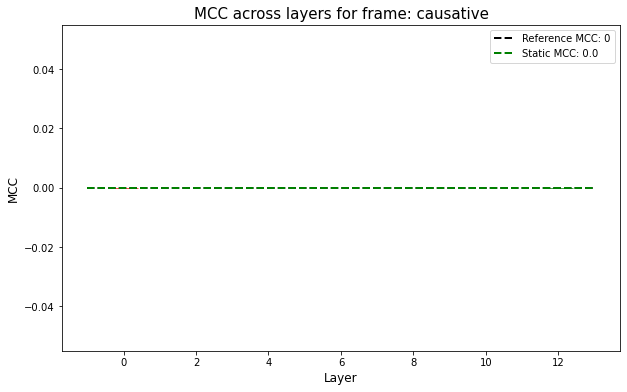

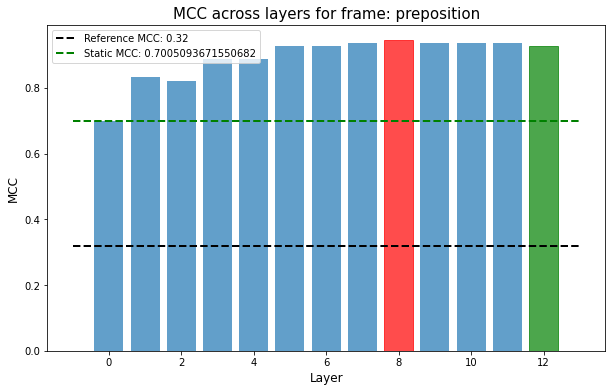

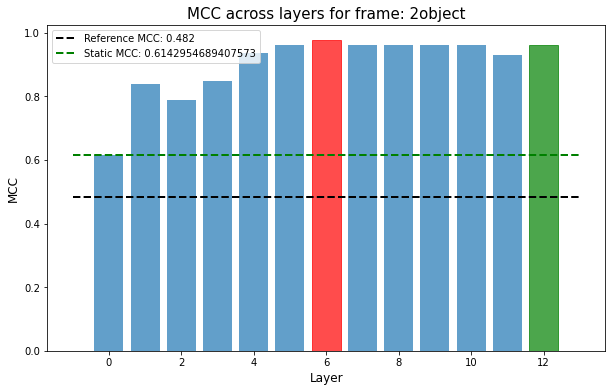

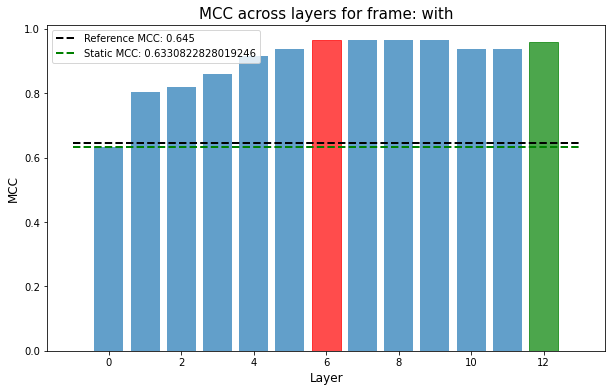

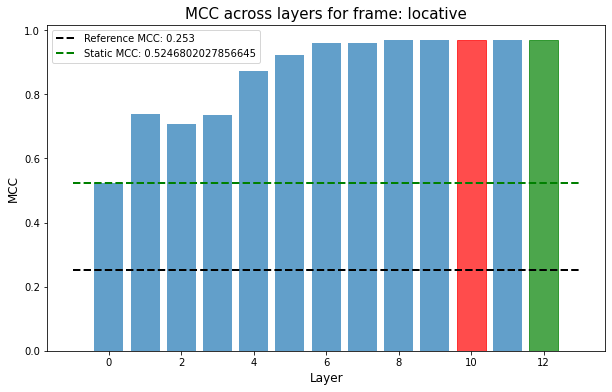

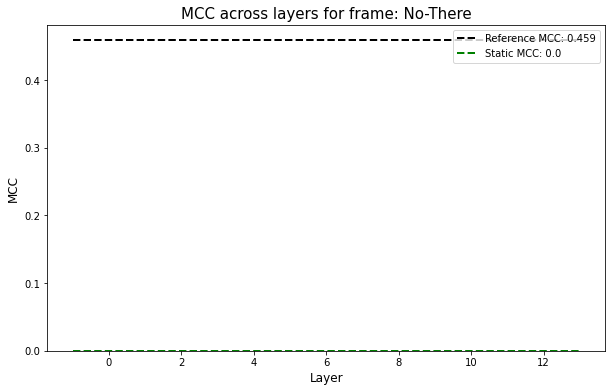

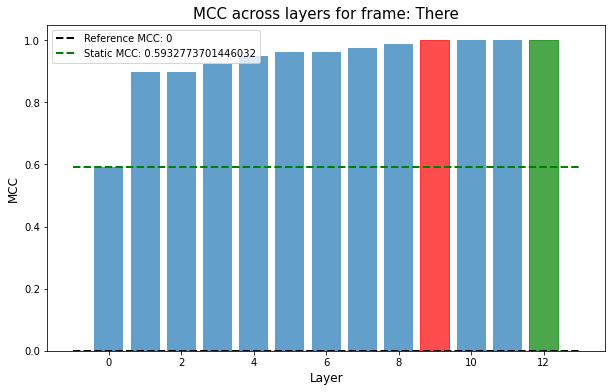

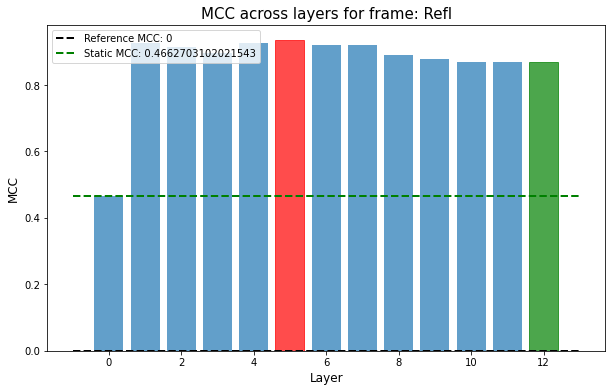

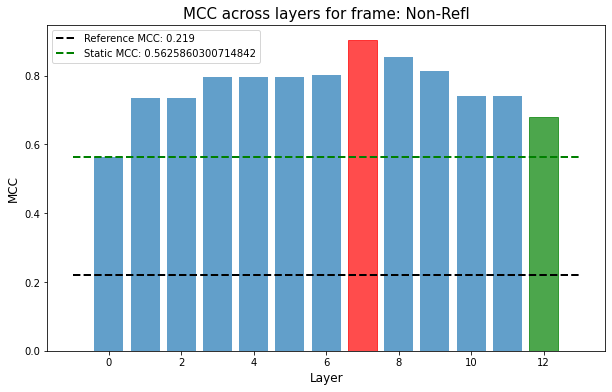

In [6]:
best_layers = []
best_mccs = []
static_mccs = []
best_accs = []
baseline_accs = []
for alternation in frames:
    alternation_df = all_df[all_df['alternation_class'] == alternation].reset_index()
    
    # Store variables to create summary df
    best_layer = alternation_df.mcc.argmax()
    best_layers.append(best_layer)
    best_mcc = alternation_df['mcc'][best_layer]
    best_mccs.append(best_mcc)
    best_accs.append(alternation_df['accuracy'][best_layer])
    baseline_accs.append(alternation_df['baseline_accuracy'][best_layer])
    static_mcc = alternation_df[alternation_df['layer'] == 0]['mcc'].item()
    static_mccs.append(static_mcc)

    # Create barplot
    plt.figure(figsize=(10, 6))
    fig = plt.bar(alternation_df.layer, alternation_df.mcc, alpha=0.7)
    fig[best_layer].set_color('r')
    fig[-1].set_color('g')

    # Reference MCC Baseline
    plt.hlines(y=ref[alternation], xmin=-1, xmax=13, linestyles='--', lw=2, color='black', label=f'Reference MCC: {ref[alternation]}')
    # Static MCC Baseline
    plt.hlines(y=static_mcc, xmin=-1, xmax=13, linestyles='--', lw=2, color='green', label=f'Static MCC: {static_mcc}')

    plt.title(f'MCC across layers for frame: {alternation}', fontsize=15)
    plt.xlabel('Layer', fontsize=12)
    plt.ylabel('MCC', fontsize=12)
    plt.legend()
    plt.show()

In [7]:
all_df.groupby('layer')[['alternation_class', 'mcc']].agg(list).mcc[1]

[0.9591924960031258,
 0.8973045549642868,
 0.0,
 0.7379612152391006,
 0.927586847910944,
 0.8377350583440215,
 0.804740094823355,
 0.0,
 0.7349053669375499,
 0.8325376032096938]

<AxesSubplot:xlabel='Frame', ylabel='Layer'>

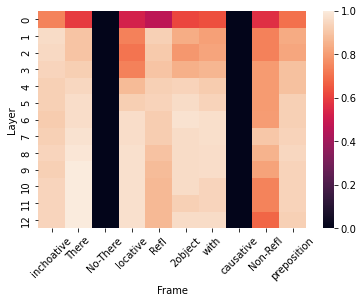

In [8]:
# Heatmap of layer performance
layer_mccs = np.array(all_df.groupby('layer')[['mcc']].agg(list).reset_index()['mcc'].values.tolist())
map = sns.heatmap(layer_mccs, xticklabels=all_df['alternation_class'].unique())
plt.xlabel('Frame')
plt.ylabel('Layer')
plt.xticks(rotation=45)
map

In [9]:
"""
Note: No-there, causative are expected to have 0 MCC since they only have one class
We suspect there is error in the author's evaluation reports, and they switched their metrics for
there/no-there and refl/non-refl
"""

pd.DataFrame(data={
    'Frame': frames, 
    'BERT layer': best_layers,
    'Layer MCC': best_mccs,
    'Reference MCC': ref_mcc,
    'Static MCC': static_mccs, 
    'Baseline Accuracy': baseline_accs,
    'Accuracy': best_accs
    }
)

,Frame,BERT layer,Layer MCC,Reference MCC,Static MCC,Baseline Accuracy,Accuracy
0,inchoative,1,0.959192,0.555,0.741127,0.663594,0.981567
1,causative,0,0.000000,0.000,0.000000,1.000000,1.000000
2,preposition,8,0.945349,0.320,0.700509,0.852941,0.986425
3,2object,6,0.976213,0.482,0.614295,0.856589,0.994186
4,with,6,0.965015,0.645,0.633082,0.705539,0.985423
5,locative,10,0.968962,0.253,0.524680,0.749271,0.988338
6,No-There,0,0.000000,0.459,0.000000,1.000000,1.000000
7,There,9,1.000000,0.000,0.593277,0.793388,1.000000
8,Refl,5,0.934725,0.000,0.466270,0.833002,0.982107
9,Non-Refl,7,0.902741,0.219,0.562586,0.978599,0.996109
